In [87]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import pandas as pd
import numpy as np

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import process
from IPython.display import display, Math, Latex


mpl.rcParams['legend.fontsize'] = 10

# **Question:** What does it take to make a car lose control while cornering?

Given a car with a known mass, wheelbase and tire characteristics, what kind of inputs can a driver safely make without losing control and spinning out?

# **Model**

To answer this question, we used a model of the frictional forces acting on the driven rear wheels and the steering front wheels of a car.

For the sake of simplicity, we made a few assumptions to make our model more manageable. We considered weight transfer to be negligeable which meant that we were able to go with a single track (one front and one rear wheel) model of a vehicle. In addition, we assumed that no driving or braking torques would be applied to the front wheel, so we were able to disregard the longitudinal component of its frictional force. We also ignored air resistance of the vehicle and rolling resistance of the axles.

We feel that these are safe assumptions because, although there are other forces acting on an automobile in motion, friction is by far the most important to the path it takes. It is valid to sacrifice some fidelity for an attempt to make the model more manageable.

**Variables Used:**

**positive -> counterclockwise for all angles, everything is in SI base units and all angles in radians**

alpha = angle of slip between wheel and wheel velocity 

beta  = angular displacement of the car relative to the X axis

Wb    = rate of change of beta 

gamma = angle of slideslip between velocity vector and longitudinal axis of car


delta = steering angle

w     = driven (rear) wheel angular speed


X, Y, Vx, Vy = position and velocity of the car in the x-y plane


r = tire radius

I = moment of inertia of the car about its center of gravity

l = wheelbase of car

m = mass of car

B, C, D, E, K = Tire parameters for BNP Magic Formula

In [95]:
#Control inputs

#Rear wheel speed as a function of time
def wFunc(t):
    #sets rear wheel speed to a constant 10 rads / sec
    w = 10
    return w

deg = np.pi/180

#Steering angle as a function of time
def dFunc(t):
    #sets steering angle to a constant 30 degrees
    d = -30*deg

    return d

#Parameters of the car
r = 0.3         #radius of the tires
I = 2500        #car's moment of inertia about the center of gravity
l = 2.52        #wheelbase, distance between front and rear axle
m = 1250        #mass of the car

#P225/60R16 tire parameters for the BNP Magic formula
Fxk = Params(B = 0.12, C = 1.48, D = 3308, E = 0.01, K = 100)
Fya = Params(B = 0.08, C = 1.44, D = 6004, E = -1.84, K = 90)


,values
B,0.08
C,1.44
D,6004.00
E,-1.84
K,90.00


Our model takes rear wheel speed and steering angle as its inputs, as those are the variables you can reasonably control as a driver. All initial conditions are set to zero as a reference point, except for initial velocity which is calculated as the tire radius times the initial angular speed of the rear wheel. We feel it is safe to assume that the car had accelerated safely to whichever speed the driver chooses to begin their w function.

In [67]:
def make_system(wFunc, dFunc, end, dt):
    """Generates a system obejct to be used with update_func
        
    wFunc: rear wheel angular speed (rads / sec) as a function of time (seconds)
    dFunc: steering angle (radians) as a function of time (seconds)
    end:   length of time to run the simulation (seconds)
    dt:    length of each time step (seconds)
    
    returns: System Object
    """
    system = System(init = State(Vx = r*wFunc(0), Vy = 0, X = 0, Y = 0, B = 0, Wb=0),
                debug = State(af = 0, ar = 0, kf = 0, kr = 0, w = wFunc(0), g = 0, d = dFunc(0), theta = 0, FlongitudinalF = 0, FlongitudinalR = 0, 
                              FlateralF = 0, FlateralR = 0, Fxwf = 0, Fywf = 0, Fxf = 0, Fyf = 0, Fxr = 0, Fyr = 0, Torque = 0),
                wFunc = wFunc,
                dFunc = dFunc,
                r = r,
                I = I,
                l = l,
                m = m,
                Fxk = Fxk,
                Fya = Fya,
                t_0 = 0,
                dt  = dt,
                t_end = end)
    
    return system

In [68]:
def make_system_ODE(wFunc, dFunc, end):
    """Generates a system obejct to be used with ODE Solver
        
    wFunc: rear wheel angular speed (rads / sec) as a function of time (seconds)
    dFunc: steering angle (radians) as a function of time (seconds)
    end:   length of time to run the simulation (seconds)
    
    returns: System Object
    """
    system = System(init = State(Vx = r*wFunc(0), Vy = 0, X = 0, Y = 0, B = 0, Wb = 0),
                wFunc = wFunc,
                dFunc = dFunc,
                r = r,
                I = I,
                l = l,
                h = h,
                m = m,
                Fxk = Fxk,
                Fya = Fya,
                t_0 = 0,
                t_end = end)

    return system

We chose to implement our model both as an ODE solver to gain a better understanding of the differential equations and physics acting in the system, and as an update func due to its versatility, debugging tools, and quicker runtimes.

In [69]:
system = make_system(wFunc, dFunc, 10, 0.01)
systemODE = make_system_ODE(wFunc, dFunc, 10)

,values
init,Vx 3.0 Vy 0.0 X 0.0 Y 0.0 B ...
wFunc,<function wFunc at 0x7f0493708400>
dFunc,<function dFunc at 0x7f0493708158>
r,0.3
I,2500
l,2.52
h,0.28
m,1250
Fxk,B 0.12 C 1.48 D 3308.00 E ...
Fya,B 0.08 C 1.44 D 6004.00 E ...


<img src='FBD.jpg' width=300 title='FBD'>

Our model at its core comes down to 3 differential equations:

In [93]:
display(Math(r'\sum {F_{x}} = m {\frac{{\mathrm{d} }^{2}x}{\mathrm{d} {t^{2}}}}'))
print()
display(Math(r'\sum {F_{y}} = m {\frac{{\mathrm{d} }^{2}y}{\mathrm{d} {t^{2}}}}'))
print()
display(Math(r'\sum {\tau } = I {\frac{{\mathrm{d} }^{2}\beta }{\mathrm{d} {t^{2}}}}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Which, due to our limitation to first order ODEs become

In [94]:
display(Math(r'\sum {F_{x} } = m {\frac{{\mathrm{d} }v_{x} }{\mathrm{d} t}}\; \; \; \; \; v_{x} = \frac{\mathrm{d} x}{\mathrm{d} t}'))
print()
display(Math(r'\sum {F_{x} } = m {\frac{{\mathrm{d} }v_{y} }{\mathrm{d} t}}\; \; \; \; \; v_{y} = \frac{\mathrm{d} y}{\mathrm{d} t}'))
print()
display(Math(r'\sum {\tau  } = I {\frac{{\mathrm{d} }\omega _{\beta } }{\mathrm{d} t}}\; \; \; \; \; \omega _{\beta } = \frac{\mathrm{d} \beta }{\mathrm{d} t}'))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The complexity of the model comes in the way the forces are calculated. Friction at each wheel is sequentially calculated from two different formulas, which rely on the angle and ratio of slip relative to the orientation of each wheel which is part of the cars axes which are constantly changing relative to the X-Y plane based on the angular displacement, which is in turn governed by those forces, and everything is constantly needing to be componentized and it gets out of hand quite quickly. Because of this, a large part of our python implementation was centered around breaking down these convoluted calculations into function calls.

In [71]:
def gamma(Vx, Vy, B):
    """Calculates angle gamma (in radians) between the positive Longitudnial axis of the car and the velocity vector 
        
    Vx: velocity of the center of gravity of the car in the X direction (meters / sec)
    Vy: velocity of the center of gravity of the car in the Y direction (meters / sec)
    B:  angular displacement beta between the car's Longitudinal axis and the positive X axis (radians)
    
    returns: float
    """
    
    #prevent dividing by zero
    if Vx == 0:
        Vx = 1e-99
        
    theta = np.arctan(Vy / Vx)
    
    #calculates theta as total angular displacement
    if(Vx < 0):
        theta += np.pi
    elif(Vy < 0):
        theta += 2*np.pi
        
    revs = B // (2*np.pi)
    theta += revs * 2 * np.pi
        
    g = theta - B
    return g

In [72]:
def norm(x, y):
    """Calculates absolute value of a vector
        
    x: X component
    y: Y component
    
    returns: float
    """
    
    norm = (x**2+y**2)**.5
    return norm

In [75]:
def AlphaF(sys, Vx, Vy, B, Wb, g, d):
    """Calculates slip angle alpha (in radians) between the direction the front wheel is pointed and the velocity of the wheel
    
    sys: System Object
    Vx:  velocity of the center of gravity of the car in the X direction (meters / sec)
    Vy:  velocity of the center of gravity of the car in the Y direction (meters / sec)
    B:   angular displacement beta between the car's Longitudinal axis and the positive X axis (radians)
    Wb:  rate of change of beta, angular speed of the car rotating about its center of gravity (radians / sec)
    g:   angle gamma between the positive Longitudnial axis of the car and the velocity vector (radians)
    d:   steering angle delta between the Longitudinal axis of the car and the direction the front wheel is pointed (radians)
    
    returns: float
    """
    unpack(sys)
    
    #Recomponentizes velocity relative to Longitudinal axis of the car
    V = norm(Vx, Vy)
      
    Vlongitudinal = V * np.cos(g)
    Vlateral      = V * np.sin(g)
    
    #Factors rotational speed around Cg to find the velocity components acting on the front wheel
    VlongitudinalF = Vlongitudinal
    VlateralF      = Vlateral + Wb * (l/2)
    
    #prevents division by zero
    if(VlongitudinalF == 0):
        VlongitudinalF = 1e-99
    
    #Finds angle of slip relative to the Longitudinal axis
    a = np.arctan(VlateralF / VlongitudinalF)

    #corrects for steering angle
    af = a - d
    
    return af
    
    
def AlphaR(sys, Vx, Vy, B, Wb, g):
    """Calculates slip angle alpha (in radians) between the direction the rear wheel is pointed and the velocity of the wheel
    
    sys: System Object
    Vx:  velocity of the center of gravity of the car in the X direction (meters / sec)
    Vy:  velocity of the center of gravity of the car in the Y direction (meters / sec)
    B:   angular displacement beta between the car's Longitudinal axis and the positive X axis (radians)
    Wb:  rate of change of beta, angular speed of the car rotating about its center of gravity (radians / sec)
    g:   angle gamma between the positive Longitudnial axis of the car and the velocity vector (radians)
    
    returns: float
    """
    
    unpack(sys)
    
    #Recomponentizes velocity relative to Longitudinal axis of the car
    V = norm(Vx, Vy)
    
    Vlongitudinal = V * np.cos(g)
    Vlateral      = V * np.sin(g)
    
    #Factors rotational speed around Cg to find the velocity components acting on the front wheel
    VlongitudinalR = Vlongitudinal
    VlateralR      = Vlateral - Wb * (l/2)
    
    #prevents division by zero
    if(VlongitudinalR == 0):
        VlongitudinalR = 1e-99
        
    #Finds angle of slip relative to the longitudinal axis
    ar = np.arctan(VlateralR / VlongitudinalR)
    
    return ar

In [76]:
def slip(sys, Vx, Vy, g, w, t):
    """Calculates slip ratio (dimensionless) of the driven rear wheel
    
    sys: System Object
    Vx:  velocity of the car in the X direction (meters / sec)
    Vy:  velocity of the car in the Y direction (meters / sec)
    g:   angle gamma between the positive Longitudnial axis of the car and the velocity vector (radians)
    w:   function of time that gives rear wheel angular speed in radians / sec
    t:   time displacement from the beginning of the simulation (seconds)
    
    returns: float
    """
    
    unpack(sys)
    
    #Recomponentizes velocity relative to Longitudinal axis of the car
    V = norm(Vx, Vy)
    
    Vlongitudinal = V * np.cos(g)
    
    #Prevent division by zero
    if(Vx == 0 and Vy == 0 and w(t) == 0):
        K = 1
    else:
        K = (r * w(t) - Vlongitudinal) / (r * w(t))
    
    #print("slip")
    #print(K)
    
    return K

In [78]:
def BNPFrictionX(sys, k):
    """Calculates friction (in Newtons) in the Longitudinal direction of the wheel as a function of slip ratio k
       (Fx(k) from the BNP Magic formula)
    
    sys: System Object, Fxk contains parameters representing tire frictional characteristics
    k:   slip ratio of Longitudinal velocity to tangential velocity from wheel rotation
    
    returns: float
    """  
    unpack(sys)
    
    #Implementing BNP Magic Formula
    phi = (1-Fxk.E)*Fxk.K*k + (Fxk.E/Fxk.B)*np.arctan(Fxk.B*Fxk.K*k)
    Fx  = Fxk.D*np.sin(Fxk.C*np.arctan(Fxk.B*phi))

    
    return Fx

def BNPFrictionY(sys, a):
    """Calculates friction (in Newtons) in the Lateral direction of the wheel as a function of slip angle alpha (in radians)
       (Fy(a) from the BNP Magic formula)
    
    sys: System Object, Fya contains parameters representing tire frictional characteristics
    a:   slip angle alpha (in radians) between the direction the wheel is pointed and the velocity of the wheel
    
    returns: float
    """
    unpack(sys)

    #Implementing BNP Magic Formula
    phi = (1-Fya.E)*Fya.K*a + (Fya.E/Fya.B)*np.arctan(Fya.B*Fya.K*a)
    Fy  = Fya.D*np.sin(Fya.C*np.arctan(Fya.B*phi))
    
    return Fy

In [79]:
def NCForceLongitudinal(sys, a, k):
    """Implements the Nicholas comstock model for tire force to calculate friction (in Newtons) in the Longitudinal direction of the wheel as a function of 
       slip angle alpha (in radians) and slip ratio k using the Longitudinal and Lateral components of friction from the BNP Magic Formula
    
    sys: System Object, Fxk contains parameters representing tire frictional characteristics
    a:   slip angle alpha (in radians) between the direction the wheel is pointed and the velocity of the wheel
    k:   slip ratio of Longitudinal velocity to tangential velocity from wheel rotation
    
    returns: float
    """
    unpack(sys)    
    
    Fx = BNPFrictionX(sys, k)
    Fy = BNPFrictionY(sys, a)
    
    #implements model
    num   = Fx*Fy*k
    denom = (k**2 * Fy**2 + Fx**2 * np.tan(a)**2)**.5
    
    #Prevents division by zero
    if(denom == 0):
        return Fx
    
    F = num/denom
    
    return F

def NCForceLateral(sys, a, k):
    """Implements the Nicholas comstock model for tire force to calculate friction (in Newtons) in the Lateral direction of the wheel as a function of 
       slip angle alpha (in radians) and slip ratio k using the Longitudinal and Lateral components of friction from the BNP Magic Formula
    
    sys: System Object, Fxk contains parameters representing tire frictional characteristics
    a:   slip angle alpha (in radians) between the direction the wheel is pointed and the velocity of the wheel
    k:   slip ratio of Longitudinal velocity to tangential velocity from wheel rotation
    
    returns: float
    """
    unpack(sys)    
    
    Fx = BNPFrictionX(sys, k)
    Fy = BNPFrictionY(sys, a)
    
    #implements model
    num   = Fx*Fy*np.tan(a)
    denom = (k**2 * Fy**2 + Fx**2 * np.tan(a)**2)**.5
    
    #prevents division by zero
    if(denom == 0):
        return Fy
    
    F = num/denom
    
    return F

Our simulation implements the Nicholas-Comstock model for tire friction which estimates the force on the wheels as a function of tire slip and slip angle. The frictions themselves were calculated using the Bakker-Nyborg-Pacejka formula based on experimentally detemined coefficients that represent the individual properites of a P225/60R16 tire.

In [80]:
def slopeFunc(state, t, sys):
    """Calculates the rates of change of the state variables with respect to time (seconds)
        
    state:  contains positional information about the car in the X-Y plane
        X:  displacement of the center of gravity in the X direction (meters)
        Y:  displacement of the center of gravity in the Y direction (meters)
        Vx: Velocity of the center of gravity in the X direction (meters / sec)
        Vx: Velocity of the center of gravity in the X direction (meters / sec)
        B:  angular displacement beta between the car's Longitudinal axis and the positive X axis (radians)
        Wb: rate of change of beta, angular speed of the car rotating about its center of gravity (radians / sec)
        
    t:   time displacement from the beginning of the simulation (seconds)
    sys: System Object
    
    returns: dVxdt, dVydt, dXdt, dYdt, dBdt, dWbdt
    """
    unpack(sys)
    Vx, Vy, X, Y, B, Wb = state
    
    V = norm(Vx, Vy)
    
    d     = dFunc(t)

    g = gamma(Vx, Vy, B)

    #Avoiding division by zero
    if(V*np.sin(g) == 0 and not V == 0):
        af = -d
    else:
        af = AlphaF(sys, Vx, Vy, B, Wb, g, d)
    
    if(t==0):
        ar = 0
    else:
        ar = AlphaR(sys, Vx, Vy, B, Wb, g)
    
    kf = 1e-99
    kr = slip(sys, Vx, Vy, g, wFunc, t)
    
    
    #Calculate front wheel force components:
    
    Fxwf = 0
    #This force is assumed to be zero due to an assumed lack of rolling resistance, braking, and driving torques on the front wheel
    
    #calculates force normal to the front wheel's Longitudinal axis
    if(af == 0):
        Fywf = 0
    else:
        Fywf = -BNPFrictionY(sys, af)
    
    #recomponentizes front force to the Lateral and Longitudincal axes of the car
    FlongitudinalF = - np.sin(d) * Fywf
    FlateralF      = np.cos(d)  * Fywf
    
    #recomponentizes force to the X-Y plane
    Fxf = FlongitudinalF * np.cos(B) - FlateralF * np.sin(B)
    Fyf = FlongitudinalF * np.sin(B) + FlateralF * np.cos(B)

    
    #Calculate rear wheel force components while avoiding division by zero
    if kr == 0:
        if kr == 0 and ar == 0:
            FlongitudinalR = 0
            FlateralR      = 0
        FlongitudinalR = 0
        FlateralR      = BNPFrictionY(sys, ar)
    elif ar == 0:
        FlongitudinalR = BNPFrictionX(sys, kr)
        FlateralR      = 0
    else:
        FlongitudinalR = NCForceLongitudinal(sys, ar, kr)
        FlateralR      = NCForceLateral(sys, ar, kr)
    
    #recomponentizes rear force to the Lateral and Longitudincal axes of the car
    Fxr = FlongitudinalR * np.cos(B) - FlateralR * np.sin(B)
    Fyr = FlongitudinalR * np.sin(B) + FlateralR * np.cos(B)
    
    #calculates sum of the forces in the X and Y directions and the sum of the torques acting on the car
    Fx = Fxf + Fxr
    Fy = Fyf + Fyr
    T = (l / 2) * (FlateralF-FlateralR)
    
    '''
    #debug information for ODE solver
    if(t % 1 < 0.000001):
        print('t = ' + str(t))
        print('Steering angle:   ' + str(d))
        print('Rear wheel speed: ' + str(wFunc(t)))
        print('Position:            (' + str(X)    + ', ' + str(Y)    + ')')
        print('Velocity:            (' + str(Vx)   + ', ' + str(Vy)   + ')')
        print('Force:               (' + str(Fx)   + ', ' + str(Fy)   + ')')
        print('At front:            (' + str(Fxf)  + ', ' + str(Fyf)  + ')')
        print('At rear:             (' + str(Fxr)  + ', ' + str(Fyr)  + ')')
        print('At front wheel axes: (' + str(Fxwf) + ', ' + str(Fywf) + ')')
        print('At front axlw axes:  (' + str(FlongitudinalF)  + ', ' + str(FlateralF)  + ')')
        print('At rear axle axes:   (' + str(FlongitudinalR)  + ', ' + str(FlateralR)  + ')')
        print('Front Friction:      (' + str(BNPFrictionX(sys, kf))  + ', ' + str(BNPFrictionY(sys, af))  + ')')
        print('Rear Friction:       (' + str(BNPFrictionX(sys, kr))  + ', ' + str(BNPFrictionY(sys, ar))  + ')')
        print('Alpha Front:     ' + str(af))
        print('Alpha Rear:      ' + str(ar))
        print('Rear Wheel Slip: ' + str(kr))
        print('Gamma:  ' + str(g))
        print('Beta:   ' + str(B))
        print('Wbeta:  ' + str(Wb))
        print('Torque: ' + str(T))
        
        print('')
    '''
    
    #calculates state variable time derivatives
    dBdt = Wb
    dWbdt = T / I
    dXdt = Vx
    dYdt = Vy
    dVxdt = Fx / m
    dVydt = Fy / m
    
    return dVxdt, dVydt, dXdt, dYdt, dBdt, dWbdt 

After finding the forces we set up our ODE solver to calculate position, velocity, and angular displacement using sum of the forces = mass times acceleration and sum of the torques = angular acceleration * moment of inertia

In [18]:
slopeFunc(systemODE.init, 0, systemODE)

(-2.086118344703346, -3.6132629636276805, 3.0, 0.0, 0.0, -2.276355667085439)

In [19]:
resultsODE, details = run_ode_solver(systemODE, slopeFunc, max_step = 1)

In [20]:
type(resultsODE)

modsim.TimeFrame

In [21]:
details

,values
sol,None
t_events,[]
nfev,848
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


In [22]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame containing state variables, TimeFrame containing debug information
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    
    debugframe = TimeFrame(columns=debug.index)
    debugframe.row[t_0] = debug
    
    for t in linrange(t_0, t_end, dt):
        frame.row[t+dt], debugframe.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame, debugframe

Because this is such a complex system, we realized that we were going to have to do a lot of debugging. We modified the update func to create a timeframe containing all the intermediate forces and variables so that we could easily verify our calculations at various steps as well as plot them to see how they change over time.

In [84]:
def update_func(state, t, sys):
    """Calculates the change in the state variables for a given timestep
        
    state:  contains positional information about the car in the X-Y plane
        X:  displacement of the center of gravity in the X direction (meters)
        Y:  displacement of the center of gravity in the Y direction (meters)
        Vx: Velocity of the center of gravity in the X direction (meters / sec)
        Vx: Velocity of the center of gravity in the X direction (meters / sec)
        B:  angular displacement beta between the car's Longitudinal axis and the positive X axis (radians)
        Wb: rate of change of beta, angular speed of the car rotating about its center of gravity (radians / sec)
        
    t:   time displacement from the beginning of the simulation (seconds)
    sys: System Object
    
    returns: State containing positional information, State containing additional debug information
    """
    unpack(sys)
    Vx, Vy, X, Y, B, Wb = state
    
    V = norm(Vx, Vy)
    
    d     = dFunc(t)

    g = gamma(Vx, Vy, B)

    #Avoiding division by zero
    if(V*np.sin(g) == 0 and not V == 0):
        af = -d
    else:
        af = AlphaF(sys, Vx, Vy, B, Wb, g, d)
    
    if(t==0):
        ar = 0
    else:
        ar = AlphaR(sys, Vx, Vy, B, Wb, g)
    
    kf = 1e-99
    kr = slip(sys, Vx, Vy, g, wFunc, t)
    
    
    #Calculate front wheel force components:
    
    Fxwf = 0
    #This force is assumed to be zero due to an assumed lack of rolling resistance, braking, and driving torques on the front wheel
    
    #calculates force normal to the front wheel's Longitudinal axis
    if(af == 0):
        Fywf = 0
    else:
        Fywf = -BNPFrictionY(sys, af)
    
    #recomponentizes front force to the Lateral and Longitudincal axes of the car
    FlongitudinalF = - np.sin(d) * Fywf
    FlateralF      = np.cos(d)  * Fywf
    
    #recomponentizes force to the X-Y plane
    Fxf = FlongitudinalF * np.cos(B) - FlateralF * np.sin(B)
    Fyf = FlongitudinalF * np.sin(B) + FlateralF * np.cos(B)

    
    #Calculate rear wheel force components while avoiding division by zero
    if kr == 0:
        if kr == 0 and ar == 0:
            FlongitudinalR = 0
            FlateralR      = 0
        FlongitudinalR = 0
        FlateralR      = BNPFrictionY(sys, ar)
    elif ar == 0:
        FlongitudinalR = BNPFrictionX(sys, kr)
        FlateralR      = 0
    else:
        FlongitudinalR = NCForceLongitudinal(sys, ar, kr)
        FlateralR      = NCForceLateral(sys, ar, kr)
    
    #recomponentizes rear force to the Lateral and Longitudincal axes of the car
    Fxr = FlongitudinalR * np.cos(B) - FlateralR * np.sin(B)
    Fyr = FlongitudinalR * np.sin(B) + FlateralR * np.cos(B)
    
    #calculates sum of the forces in the X and Y directions and the sum of the torques acting on the car
    Fx = Fxf + Fxr
    Fy = Fyf + Fyr
    T = (l / 2) * (FlateralF-FlateralR)
    
    #calculates theta for debug info
    theta = np.arctan(Vy / Vx)
    
    if(Vx < 0):
        theta += np.pi
    
    #calculates state variable time derivatives
    dBdt = Wb
    dWbdt = T / I
    dXdt = Vx
    dYdt = Vy
    dVxdt = Fx / m
    dVydt = Fy / m
    
    #multiplies derivatives by timestep dt to approximate the change in the state variables
    Vx += dVxdt * dt
    Vy += dVydt * dt 
    X  += dXdt  * dt
    Y  += dYdt  * dt
    B  += dBdt  * dt
    Wb += dWbdt * dt
    
    return State(Vx = Vx, Vy = Vy, X = X, Y = Y, B = B, Wb = Wb), State(af = af, ar = ar, kf = kf, kr = kr, w = wFunc(t), g = g, d = dFunc(t), 
                                                                        theta = theta, FlongitudinalF = FlongitudinalF, 
                                                                        FlongitudinalR = FlongitudinalR, FlateralF = FlateralF, FlateralR = FlateralR, 
                                                                        Fxwf = Fxwf, Fywf = Fywf, Fxf = Fxf, Fyf = Fyf, Fxr = Fxr, Fyr = Fyr, Torque = T)

In [85]:
results, debug = run_simulation(system, update_func)
#results.head()

In [25]:
def plotPath(res, label):
    '''Plots the path of the center of gravity of the car in the X-Y plane
    
    res:   TimeFrame Object containing the results of the simulation
        X: displacement of the center of gravity in the X direction (meters)
        Y: displacement of the center of gravity in the Y direction (meters)
    label: identifier for the path that is being plotted
    
    returns: void
    '''
    plot(res.X, res.Y, label = str(label))
    
    decorate(xlabel = 'x position (m)',
             ylabel = 'y position (m)')
    
def plotFrontWheel(res, label):
    '''Plots the path of the front wheel of the car in the X-Y plane
    
    res:   TimeFrame Object containing the results of the simulation
        X: displacement of the center of gravity in the X direction (meters)
        Y: displacement of the center of gravity in the Y direction (meters)
        B: angular displacement beta between the car's Longitudinal axis and the positive X axis (radians)
    label: identifier for the path that is being plotted
    
    returns: void
    '''
    plot(res.X + (l/2) * np.cos(res.B), res.Y + (l/2) * np.sin(res.B), label = 'Front Wheel ' + str(label))
    
    decorate(xlabel = 'x position (m)',
             ylabel = 'y position (m)')
    
def plotRearWheel(res, label):
    '''Plots the path of the front wheel of the car in the X-Y plane
    
    res:   TimeFrame Object containing the results of the simulation
        X: displacement of the center of gravity in the X direction (meters)
        Y: displacement of the center of gravity in the Y direction (meters)
        B: angular displacement beta between the car's Longitudinal axis and the positive X axis (radians)
    label: identifier for the path that is being plotted
    
    returns: void
    '''
    plot(res.X - (l/2) * np.cos(res.B), res.Y - (l/2) * np.sin(res.B), label = 'Rear Wheel ' + str(label))
    
    decorate(xlabel = 'x position (m)',
             ylabel = 'y position (m)')

1.0


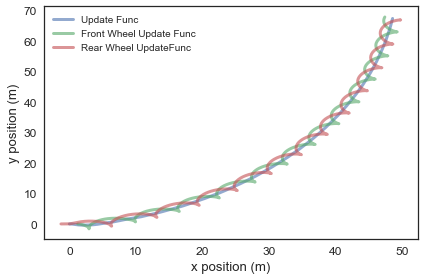

In [26]:
plotPath(results, 'Update Func')
plotFrontWheel(results, 'Update Func')
plotRearWheel(results, 'UpdateFunc')

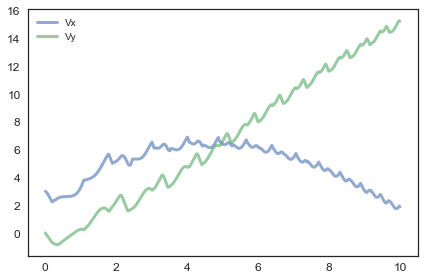

In [27]:
plot(results.Vx, label = 'Vx')
plot(results.Vy, label = 'Vy')

decorate()

# Results

at this point when we tried giving the ODE solver w and d as functions of time, it was taking hundreds of thousands of time steps, so we decided to switch to an update func instead.

In [50]:
#creation of various rear wheel angular velocity functions to sweep
def wFunc10(t):
    w = 10
    
    return w

def wFunc20(t):
    w = 20
    
    return w

def wFunc30(t):
    w = 30
    
    return w

def wFunc40(t):
    w = 50
    
    return w

def wFunc50(t):
    w = 50
    
    return w
    
#creation of various steering angle functions to sweep    
def dFunc0(t):
    d = 0*deg*(1 - np.e**(-t))
    
    return d

def dFunc1(t):
    d = 1*deg*(1 - np.e**(-t))
    
    return d

def dFunc2(t):
    d = 2*deg*(1 - np.e**(-t))
    
    return d

def dFunc3(t):
    d = 3*deg*(1 - np.e**(-t))
    
    return d

def dFunc4(t):
    d = 4*deg*(1 - np.e**(-t))
    
    return d

def dFunc5(t):
    d = 5*deg*(1 - np.e**(-t))
    
    return d

def dFunc10(t):
    d = 10*deg*(1 - np.e**(-t))
    
    return d

def dFunc15(t):
    d = 15*deg*(1 - np.e**(-t))
    
    return d

def dFunc20(t):
    d = 20*deg*(1 - np.e**(-t))
    
    return d

def dFunc25(t):
    d = 25*deg*(1 - np.e**(-t))
    
    return d

def dFunc30(t):
    d = 30*deg*(1 - np.e**(-t))
    
    return d

#creation of systems for sweeping
sys050 = make_system(wFunc50, dFunc0, 10, 0.01)
sys150 = make_system(wFunc50, dFunc1, 10, 0.01)
sys250 = make_system(wFunc50, dFunc2, 10, 0.01)
sys350 = make_system(wFunc50, dFunc3, 10, 0.01)
sys450 = make_system(wFunc50, dFunc4, 10, 0.01)
sys550 = make_system(wFunc50, dFunc5, 10, 0.01)
sys1050 = make_system(wFunc50, dFunc10, 10, 0.01)
sys1550 = make_system(wFunc50, dFunc15, 10, 0.01)
sys2050 = make_system(wFunc50, dFunc20, 10, 0.01)
sys2550 = make_system(wFunc50, dFunc25, 10, 0.01)
sys3050 = make_system(wFunc50, dFunc30, 10, 0.01)

sys510 = make_system(wFunc10, dFunc5, 10, 0.01)
sys520 = make_system(wFunc20, dFunc5, 10, 0.01)
sys530 = make_system(wFunc30, dFunc5, 10, 0.01)
sys540 = make_system(wFunc40, dFunc5, 10, 0.01)

,values
init,Vx 15.0 Vy 0.0 X 0.0 Y 0.0 B ...
wFunc,<function wFunc0 at 0x7f04977a4d08>
dFunc,<function dFunc0 at 0x7f0491b84e18>
r,0.3
I,2500
l,2.52
h,0.28
m,1250
Fxk,B 0.12 C 1.48 D 3308.00 E ...
Fya,B 0.08 C 1.44 D 6004.00 E ...


In [52]:
#running of simulations for steering angle sweep
results0, debug0 = run_simulation(sys050, update_func)
results1, debug0 = run_simulation(sys150, update_func)
results2, debug0 = run_simulation(sys250, update_func)
results3, debug0 = run_simulation(sys350, update_func)
results4, debug0 = run_simulation(sys450, update_func)
results5, debug5 = run_simulation(sys550, update_func)
results10, debug10 = run_simulation(sys1050, update_func)
results15, debug15 = run_simulation(sys1550, update_func)
results20, debug20 = run_simulation(sys2050, update_func)
results25, debug25 = run_simulation(sys2550, update_func)
results30, debug30 = run_simulation(sys3050, update_func)

We decided to look at cornering as our primary condition of concern, considering that is the time it is most dangerous to lose traction. For our first sweep we looked at  a driver entering a turn with a rear wheel angular speed of 50 rads/s (translates to about 35 mph) and then turns the wheel to a predetermined angle in degrees. A (1 - e^(-t)) curve was chosen because it exhibits an asymptotic behavior while still being continuous and differentiable along its domain and avoiding the abrupt slippage that would be caused by an instant transition from an unturned wheel to the desired angle that a constant delta function would give.

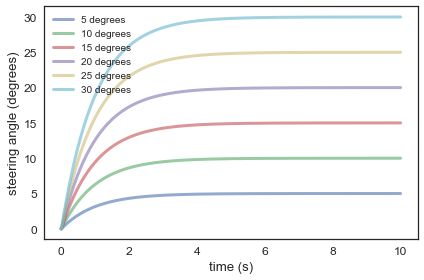

In [53]:
plot(debug5.d/deg, label = '5 degrees')
plot(debug10.d/deg, label = '10 degrees')
plot(debug15.d/deg, label = '15 degrees')
plot(debug20.d/deg, label = '20 degrees')
plot(debug25.d/deg, label = '25 degrees')
plot(debug30.d/deg, label = '30 degrees')
decorate(xlabel = 'time (s)',
             ylabel = 'steering angle (degrees)')

In [81]:
def plotCar(results, label):
    '''Plots the path of the center of gravity of the car, as well as the front and rear wheel positions in the X-Y plane
    
    results: TimeFrame Object containing the results of the simulation
    label: identifier for the paths being plotted
    
    returns: void
    '''
    plotPath(results, label)
    plotFrontWheel(results, label)
    plotRearWheel(results, label)

We wrote a program to plot the path of the car (center of gravity), along with the paths of the front and rear wheels, to give a better idea of when the car brakes traction and spins out

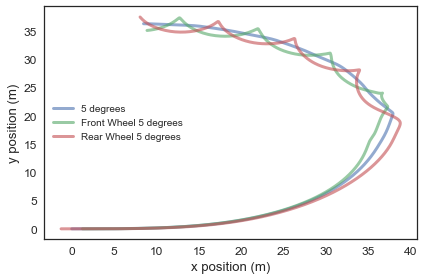

In [55]:
plotCar(results5, '5 degrees')

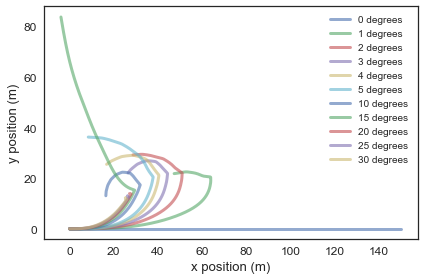

In [57]:
plotPath(results0, '0 degrees')
plotPath(results1, '1 degrees')
plotPath(results2, '2 degrees')
plotPath(results3, '3 degrees')
plotPath(results4, '4 degrees')
plotPath(results5, '5 degrees')
plotPath(results10, '10 degrees')
plotPath(results15, '15 degrees')
plotPath(results20, '20 degrees')
plotPath(results25, '25 degrees')
plotPath(results30, '30 degrees')

None of our simulated cars were able to complete the turn with a wheel speed of 50 rads / s, which meant it was time to try sweeping lower wheel speeds. The steering function, which was asymptotic to 5 degrees, was kept consistent.

In [82]:
#running simulations for a sweep of wheel speed
results510, debug510 = run_simulation(sys510, update_func)
results520, debug520 = run_simulation(sys520, update_func)    
results530, debug530 = run_simulation(sys530, update_func)    
results540, debug540 = run_simulation(sys540, update_func)    
results550, debug550 = run_simulation(sys550, update_func)    

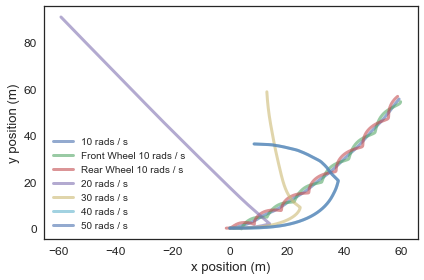

In [62]:
plotCar(results510, '10 rads / s')
plotPath(results520, '20 rads / s')
plotPath(results530, '30 rads / s')
plotPath(results540, '40 rads / s')
plotPath(results550, '50 rads / s')

As you can see, not even at low, constant speeds was our simulated car able to successfully complete the turn. The vehicle we modeled loses traction when turning at angles as low as 5 degrees at speeds as low as 3 m/s (calculated from tire radius * w).

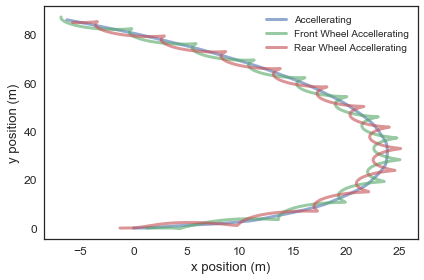

In [86]:
def wFuncAccel(t):
    #angular speed starts at 10 rads / sec and increases at a rate of 5 rads / sec^2
    w = 5 * t + 10
    
    return w

sysAccel = make_system(wFuncAccel, dFunc10, 10, 0.001)
resultsA, debugA = run_simulation(sysAccel, update_func)

plotCar(resultsA, 'Accellerating')

and having the car accelerate through the turn made things considerably worse.

# Interpretation

These results show that, although it may seem fun, cornering can acutually be highly dangerous. It's a good thing that real cars have differentials and brakes.

Well... either that, or they show that we did not successfuly implement our model in python. Our model has many flaws, but our real downfall was our hubris. We learned that there in fact was a reason that we were told not to do drifting as our project. To be fair, this isn't really a drifting project any more. If we've made progress anywhere it was at least in our question. We've come a long way from wanting to sweep a steady-state drift. Finding some magical set of wheel speed and steering angle functions that would give us the drifting we craved is also not entirely in the spirit of modsim, as there are way too many different variables and arbitrary choices to make for the results to be in any way significant. With our current question we decided to take a look at cornering in a more general sense, using our simulation to predict what will happen rather than knowing what we want to happen and trying to make it happen. Given more time to develop, this could have been a genuinely useful model for automakers and highway safety, and not just the kids that want to do donuts in their secondhand panther bodies. As we were saying, our other biggest difficulty with this problem has been time. We ended up waaaaay over scoped for our current skill levels in math, physics, and programming. Maybe there's a reason that the majority of the research that's out there was on steady state drifting. Given more time for this project, the first thing we would probably do is stop to breathe. Over the past two weeks we've spent dozens of hours to half-comprehend an obscure frictional model of tire forces, and dozens more trying, and failing, to implement it in python, banging our collective heads against the wall just to show Allen Downey that we really could do it, only to bow our half concussed head in subservience. Right now, who knows what's wrong with the model? Maybe its just a single misplaced variable, maybe we have to go back and reframe all the different axes a fourth time, maybe we have a funamental misunderstanding of the tire model, we really just don't know at this point. We might some day, but today we have to present our findings thus far. We may still not know exactly what driver control inputs allow a rear wheel drive car with no brakes and no differential to safely turn a corner, but we have learned some important lessons about project scope and humility.